In [16]:
# LOAD CLASS AND DATASET 
# dataset: https://www.kaggle.com/rmisra/news-category-dataset
# start:    each doc in corpus contains an article link, category and other (irrelevant) key/value pairs
# end goal: each doc in corpus contains a sentence with POS tagging and gender polarity, and label vector with actual gender
import sys
sys.path.append('../')

%reload_ext autoreload
%autoreload 2
from classes.data_prepper import DataPrepper

p = DataPrepper()

import pandas as pd

df = pd.read_json('../datasets/8_dataset_simple.json')
df['sentiments'] = df.Gender.apply(lambda x: 0 if x == "M" else 1)

constructor of DataPrepper


In [17]:
df

,Text,Gender,sentiments
0,At least two organizations have decided to dro...,W,1
1,Women who previously worked with the Oscar win...,W,1
2,In response to the allegations Visa announced ...,W,1
3,We are aware of the allegations that have bee...,W,1
4,At this point Visa will be suspending our mark...,W,1
...,...,...,...
668170,We can just have guys or anybody out there not...,M,0
668171,Trade rumors about the reigning Defensive Pla...,M,0
668172,Before the season Howard was said to have made...,M,0
668173,Just last week he added the new look Los Angel...,M,0


In [18]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import tensorflow as tf
tokenizer = Tokenizer(oov_token="<OOV>")

split = round(len(df)*0.8)
train_texts = df['Text'][:split]
train_label = df['sentiments'][:split]
test_texts = df['Text'][split:]
test_label = df['sentiments'][split:]

import numpy as np
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for row in train_texts:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_texts:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,       input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 0, 
                                        restore_best_weights = True)

num_epochs = 2
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), callbacks =[earlystopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16705/16705 [==============================] - 84s 5ms/step - loss: 0.4655 - accuracy: 0.7614 - val_loss: 0.3552 - val_accuracy: 0.8227
Epoch 2/100
16705/16705 [==============================] - 85s 5ms/step - loss: 0.4047 - accuracy: 0

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

<Figure size 432x288 with 0 Axes>

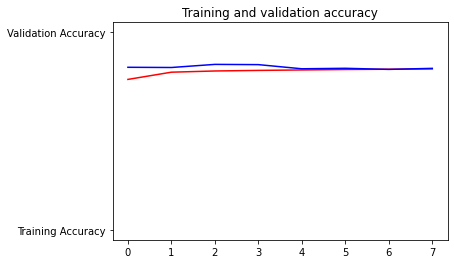

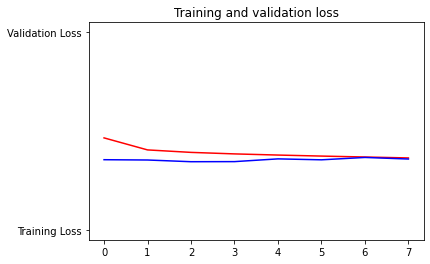

<Figure size 432x288 with 0 Axes>

In [19]:
%load_ext tensorboard
%tensorboard --logdir=./la_logs --port=6006

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [36]:
model.save('keras_simple.h5')

In [37]:
model = tf.keras.models.load_model('keras_simple.h5')